In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=16,family='serif')
import matplotlib.gridspec as gridspec
from emcee import EnsembleSampler
from emcee.backends import HDFBackend
from multiprocessing import cpu_count, Pool
from corner import corner
from Cosmology import *
import sys

#Cosmological parameters
Omega_m = 0.3089
Omega_c = 0.6911

# Import data

## Supernova data

In [2]:
dataSN = np.loadtxt('data/jla_lcparams.txt', usecols=(2,4,6,8,10))
dataSN = dataSN[np.argsort(dataSN.T[0])]
errSN = np.loadtxt('data/jla_lcparams.txt', usecols=(5,7,9))[np.argsort(dataSN.T[0])]

#best fit values found in JLA analysis arXiv:1401.4064
a = 0.14
b = 3.14
MB = -19.04
delta_Mhost = -.06

In [3]:
SNdata = Supernova_data(dataSN, errSN, np.array([a,b,MB, 0]))

## Quasar data

In [4]:
dataQ = np.loadtxt('data/quasar_data_RL.txt', usecols=(0,1,2,3,4))
dataQ = dataQ[np.argsort(dataQ.T[0])]
errQ = np.loadtxt('data/quasar_data_RL.txt', usecols=5)[np.argsort(dataQ.T[0])]

#best fit values found in Risaliti & Lusso, Nature Astronomy, 2018
beta_prime, s = 7.4, 1.5

In [5]:
Qdata = Quasar_data(dataQ, errQ, np.array([beta_prime, s]))

# Set up and run the MCMC sampler [arXiv:1202.3665]

## Define the likelihood and priors

In [6]:
def lnlike(theta, SNdata, Qdata):
    Omegam, Omegac, a, b, MB, delta_Mhost, beta_prime, s = theta
    
    LCDM = cosmology(Omegam, Omegac)
    log_prob = LCDM.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())
    log_prob += LCDM.log_likelihood(Qdata.distance_modulus(), Qdata.delta_distance_modulus())
    
    if np.isnan(log_prob):
        return -np.inf
    else:
        return log_prob


def lnprior(theta):
    Omegam, Omegac, a, b, MB, delta_Mhost, beta_prime, s = theta
    #flat priors:
    if 0 < Omegam < 1.0 and 0 < Omegac < 1.0 and -5 <= a < 5 and -10 < b < 10 and -25 < MB < 0 and -0.5 < delta_Mhost < 0.5 and 0 < s <= 3:
        return 0.0
    return -np.inf

def lnprob(theta, SNdata, Qdata):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, SNdata, Qdata)

## set up and run the MC sampler locally...

In [7]:
ndim, nwalkers, nsteps = 8, 16, 50
pos0 = [np.array([Omega_m, Omega_c, a, b, MB, 0, beta_prime, s]) + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] #, .2, 2, .1, -20]])
labs=[r'$\Omega_m$', r'$\Omega_\Lambda$', r'$\alpha$', r'$\beta$', r'$M_B$', r'$\Delta M_B$', r'$\beta^\prime$', r'$\delta$']

pool = Pool(cpu_count())
write = HDFBackend('results/LCDM_' + str(nwalkers) + 'x' + str(nsteps) + '.h5')
sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=(SNdata, Qdata), pool=pool, backend=write)

## (uncomment this cell if you want to load a preexisting chain)

In [8]:
index = 0
autocorr = np.empty(nsteps)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to nsteps steps
for i, sample in enumerate(sampler.sample(pos0, iterations=nsteps, progress=True)):
    # Only check convergence every 100 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.1)
    if converged:
        break
    old_tau = tau
pool.close()

100%|██████████| 50/50 [07:53<00:00,  7.86s/it]


## ...or load an existing chain from the cluser script

In [9]:
load_sampler = HDFBackend('results/LCDM_250x500.h5', read_only=True)

nsteps, nwalkers, ndim = load_sampler.get_chain().shape

# Check and visualise the convergence: $\tau_f / n_\mathrm{steps} < 1/100$

In [10]:
Nmin = 0
while np.mean(load_sampler.get_autocorr_time(tol=0,discard=Nmin))/(nsteps+Nmin)*50 > 1:
    Nmin+=25
    
print('Nmin = {}'.format(Nmin))

Nmin = 325


<IPython.core.display.Javascript object>


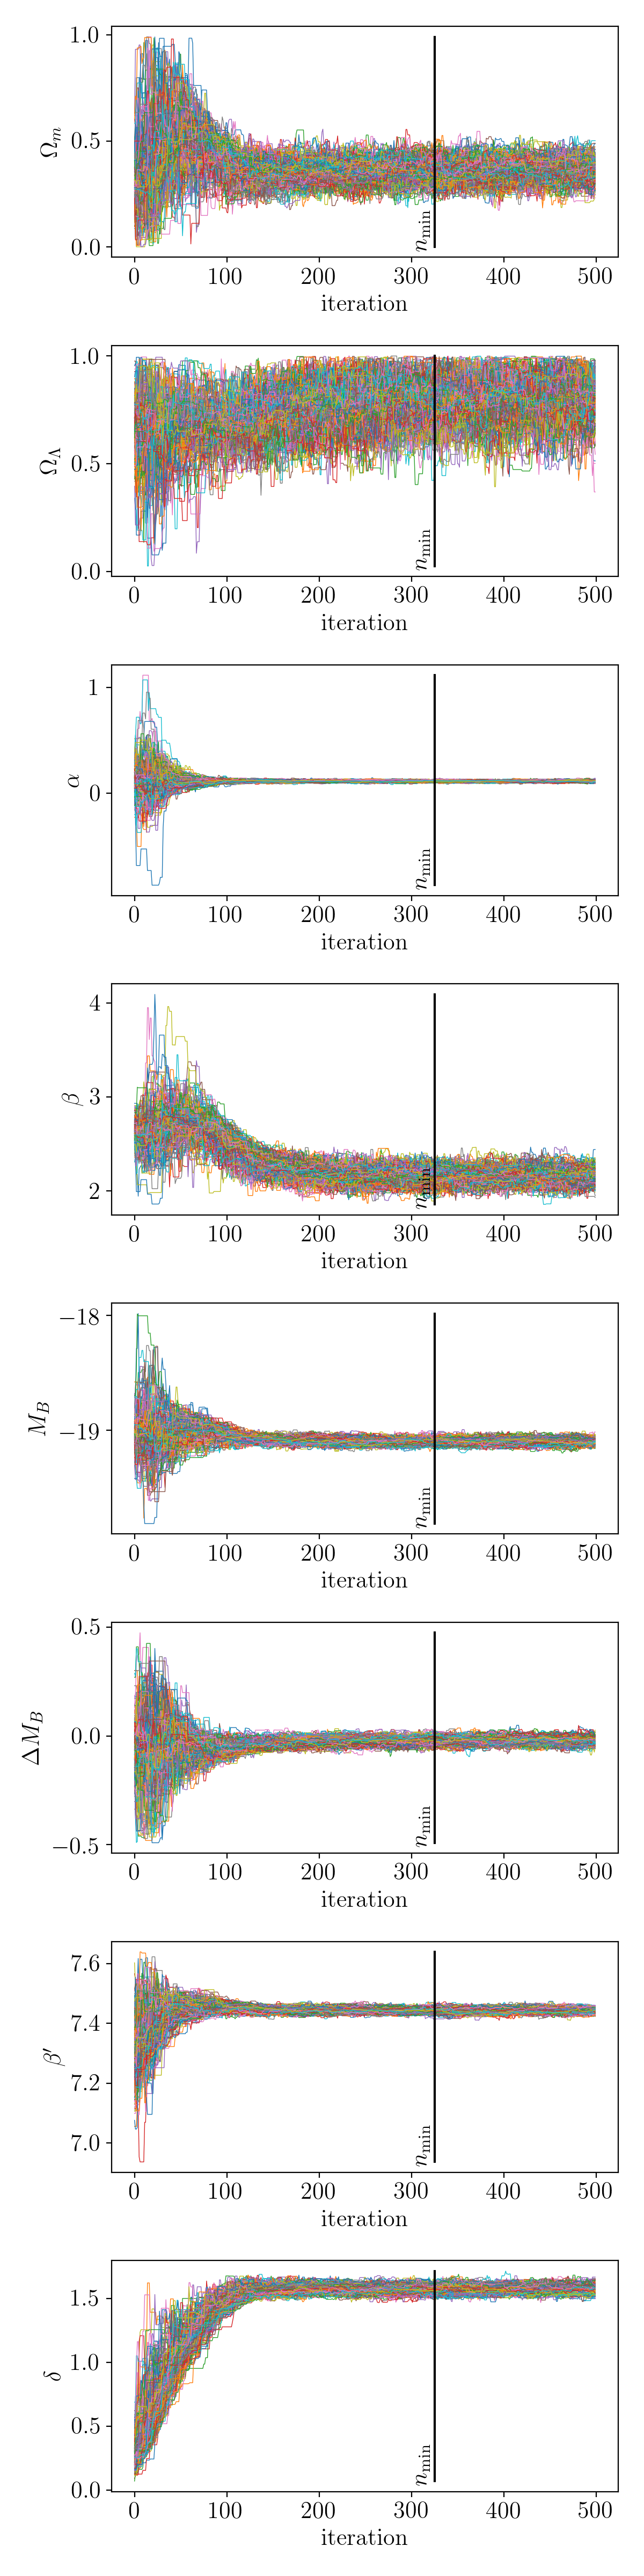

In [11]:
samples = load_sampler.get_chain()

f, ax = plt.subplots(len(samples.T), 1, figsize=(6,3*len(samples.T)))

for i in range(len(samples.T)):
    ax[i].plot(samples.T[i].T, lw=0.5)
    ax[i].plot([Nmin, Nmin], [min(samples.T[i].flatten()), max(samples.T[i].flatten())], c='k', lw=1.5)
    ax[i].text(Nmin, min(samples.T[i].flatten()), r'$n_\mathrm{min}$', rotation=90, ha='right')
    ax[i].set_ylabel(labs[i])
    ax[i].set_xlabel('iteration')
    
    
plt.tight_layout()
plt.show()

# Plot the 1$\sigma$ and 2$\sigma$ contours

<IPython.core.display.Javascript object>


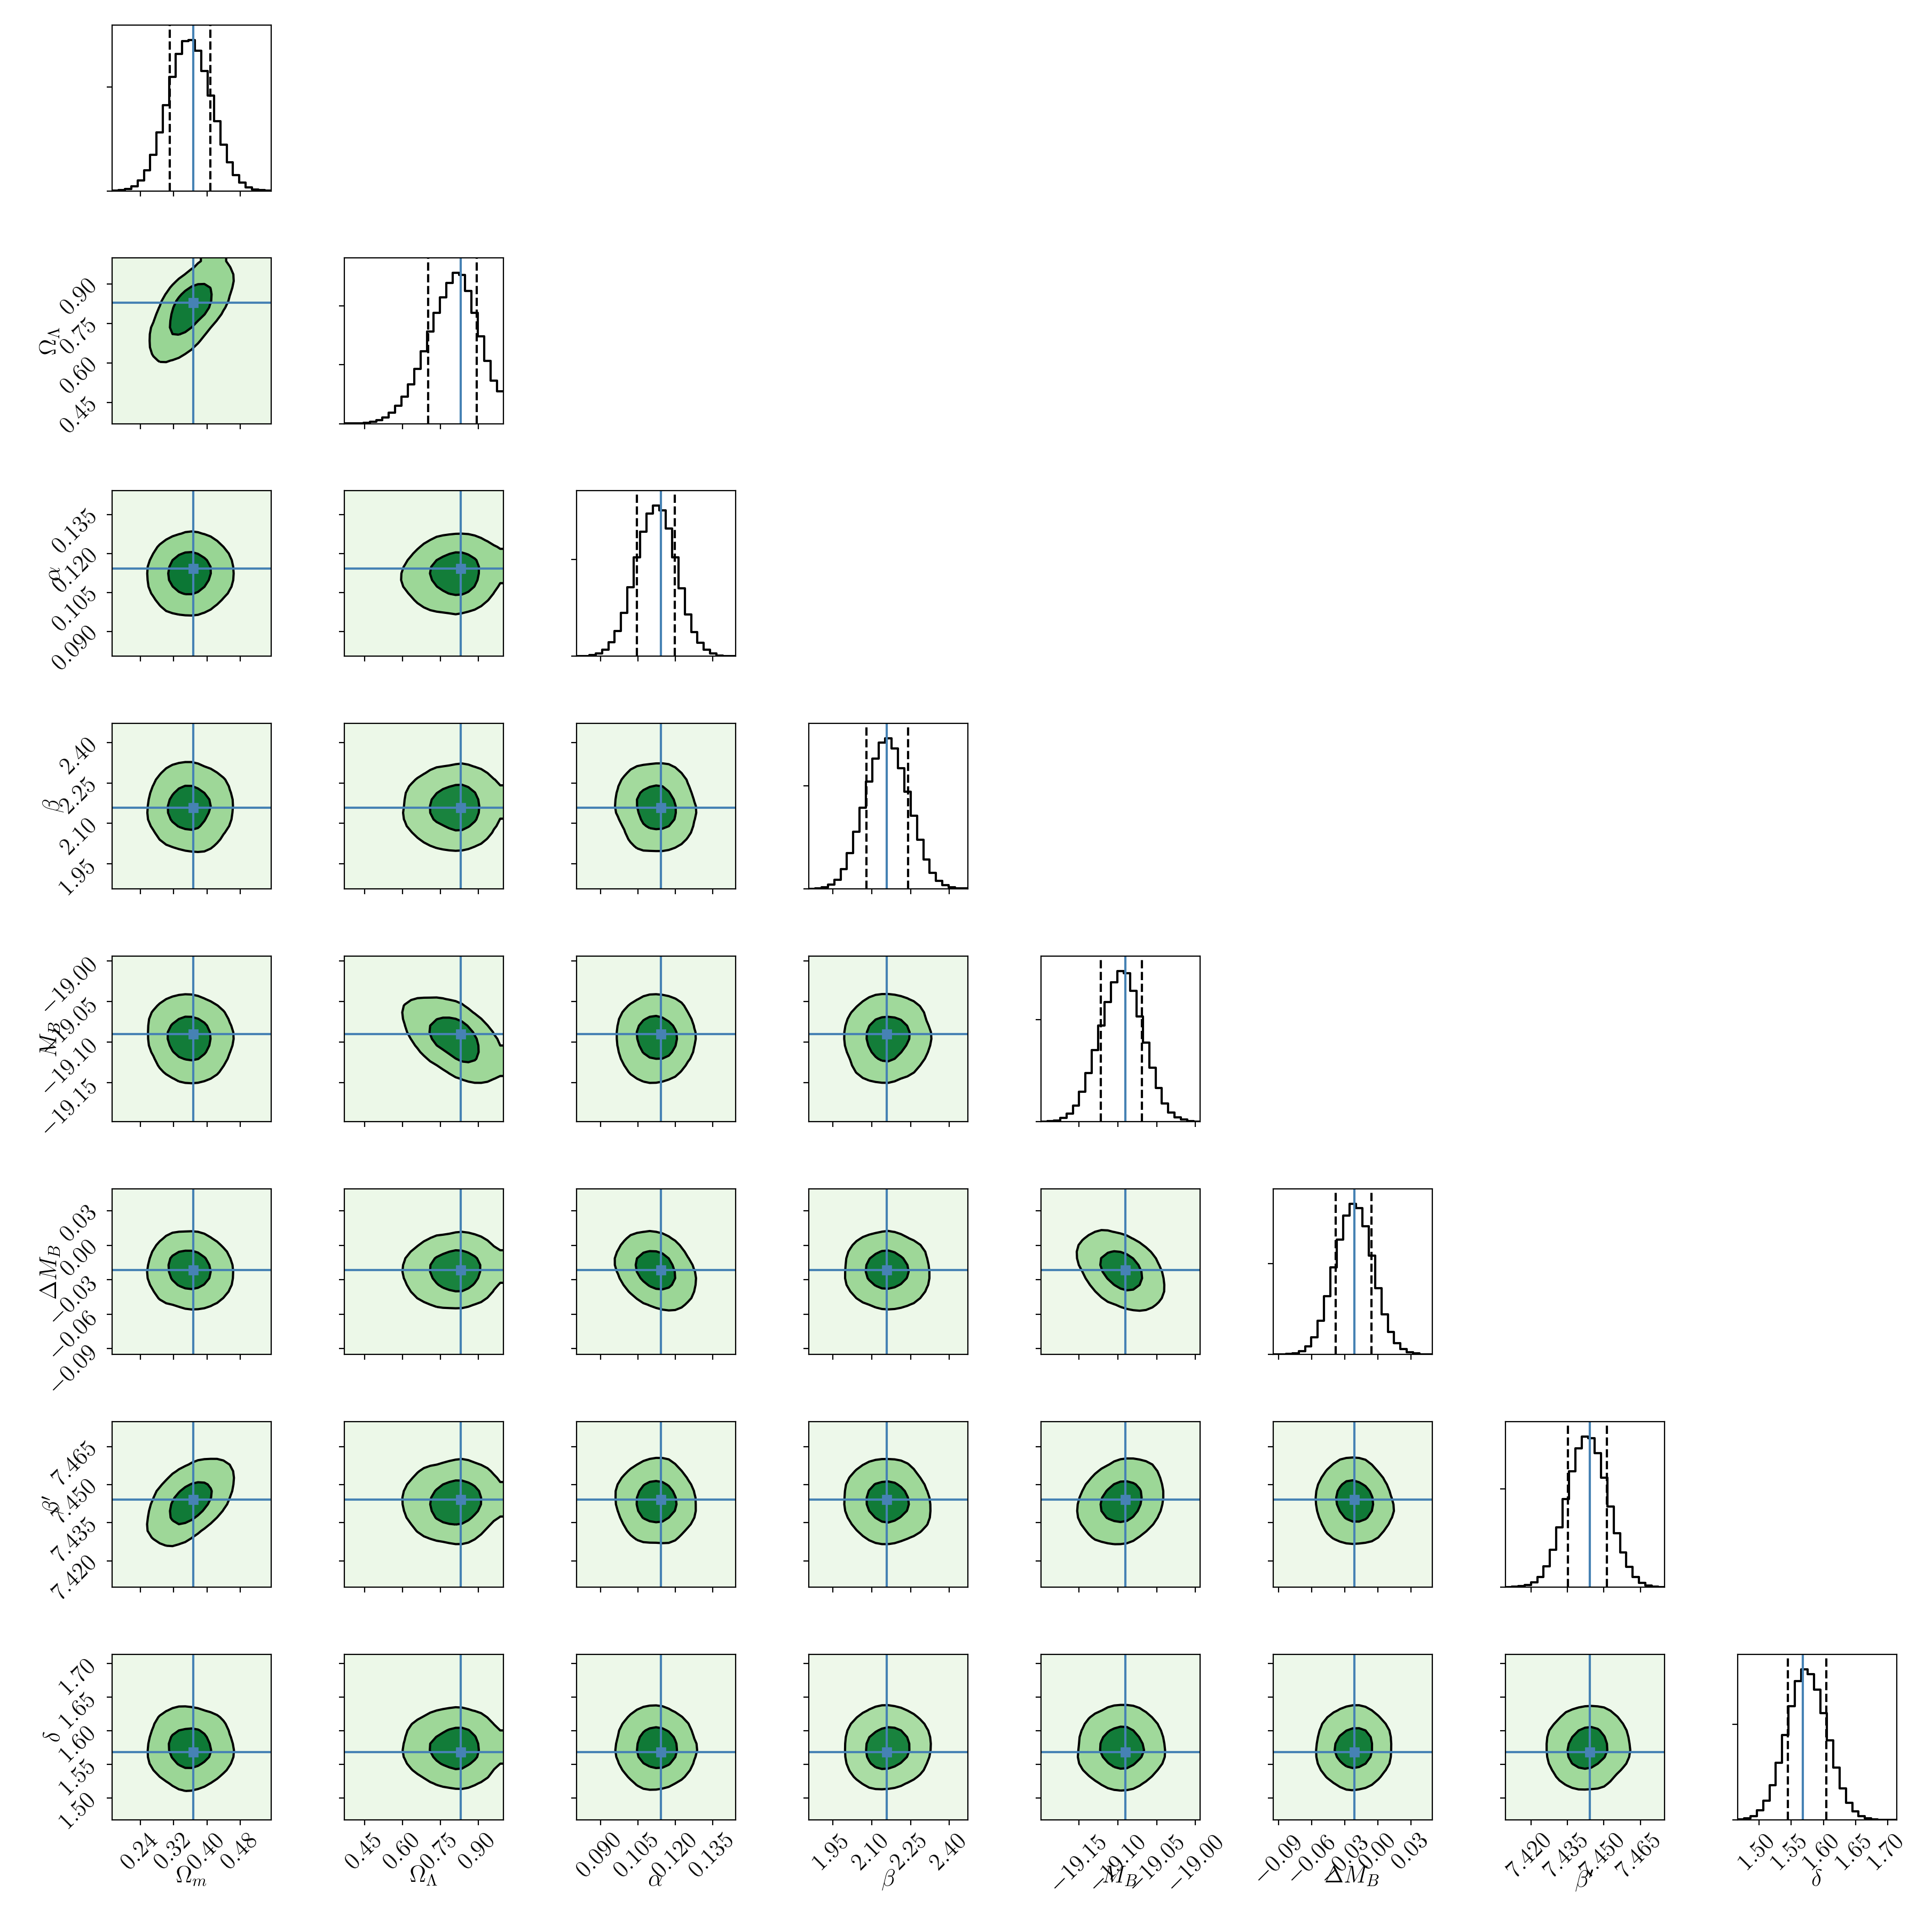

In [12]:
samples = load_sampler.get_chain()[250:, :, :].reshape((-1, ndim))


meanLCDM = np.mean(samples, axis=0)
stdLCDM = np.var(samples, axis=0)
maxLCDM=[]
for i in range(len(meanLCDM)):
    likelihood = np.histogram(samples.T[i], bins=50)
    i_max=np.argmax(likelihood[0])
    max_val = (likelihood[1][i_max]+likelihood[1][i_max+1])/2
    maxLCDM.append(max_val)


fig = corner(samples, quantiles=(.16,.84),  levels=(1-np.exp(-0.5),1-np.exp(-0.5*4)),
             labels=labs, smooth=True, smooth1d=True, bins=25, plot_datapoints=False, fill_contours=True, contourf_kwargs=dict(colors=None, cmap='Greens'),
             truths=maxLCDM)

plt.tight_layout()
plt.savefig('plots/posterior_LCDM.pdf')

# Visualize the results

In [13]:
v = np.percentile(samples,[2.5, 50, 97.5], axis = 0)
v = np.asarray([v[1], v[2]-v[1],v[1]-v[0]]).T

omegam, stdmp, stdmm = v[0]
omegac, stdcp, stdcm = v[1]

#model
z = SNdata.get_data().T[0]
best_fit_cosmo = cosmology(omegam,omegac)


<IPython.core.display.Javascript object>


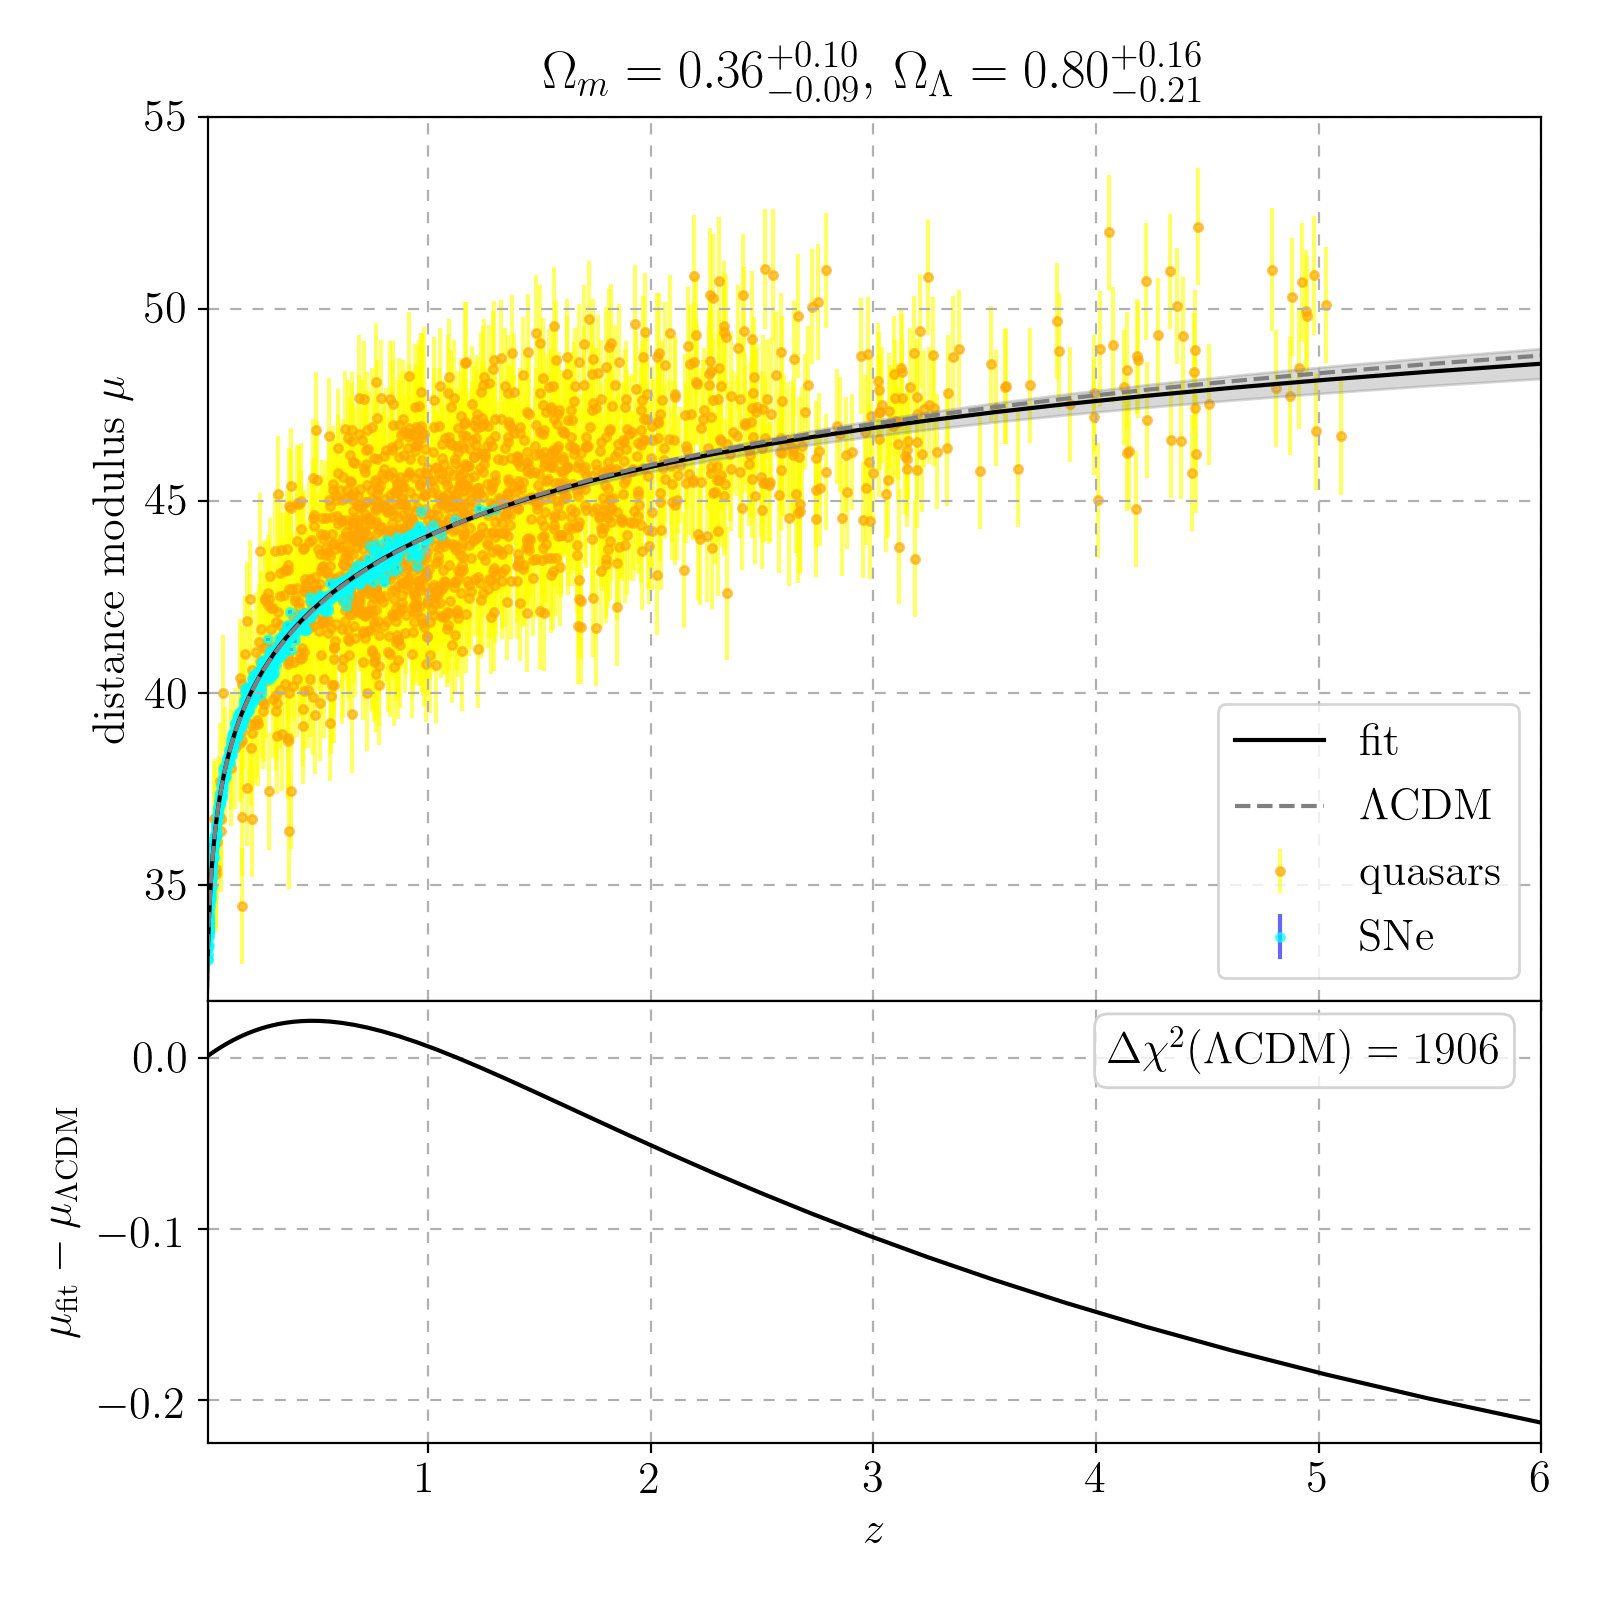

In [14]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 1)
gs.update(hspace=0)


ax1 =plt.subplot(gs[0:2, 0])
ax1.set_title('$\Omega_m = {%1.2f}^{+%1.2f}_{-%1.2f},\, \Omega_\Lambda = {%1.2f}^{+%1.2f}_{-%1.2f}$' % (omegam, stdmp,stdmm, omegac, stdcp,stdcm))#, stdkm, stdkp))

ax1.errorbar(Qdata.distance_modulus().T[0], Qdata.distance_modulus().T[1], yerr=np.diag(Qdata.delta_distance_modulus()), linestyle='none', marker='o', color='orange', ecolor='yellow', markersize=3, alpha=0.6, zorder=-1, label=r'quasars')
ax1.errorbar(SNdata.distance_modulus().T[0], SNdata.distance_modulus().T[1], yerr=np.diag(SNdata.delta_distance_modulus()), linestyle='none', marker='o', color='cyan', ecolor='blue', markersize=3, alpha=0.6, zorder=-1, label=r'SNe')




zPlot = np.logspace(-3,np.log10(6),100)
ax1.plot(zPlot, [cosmology(omegam, omegac).distance_modulus(zi) for zi in zPlot], c='k', label=r'fit')
ax1.fill_between(zPlot, [cosmology(omegam+stdmp,omegac+stdcp).distance_modulus(zi) for zi in zPlot], [cosmology(omegam-stdmm,omegac-stdcm).distance_modulus(zi) for zi in zPlot], color='gray', alpha=0.3)
ax1.plot(zPlot, [cosmology(Omega_m, Omega_c).distance_modulus(zi) for zi in zPlot], ls = '--', c='gray', label=r'$\Lambda$CDM')

ax1.set_xlim(0.01,6)
ax1.set_ylim(32,55)


ax1.set_ylabel(r'distance modulus $\mu$')
ax1.set_xticklabels([])

ax1.grid('--', dashes=(5,5))
ax1.legend()


ax2 = plt.subplot(gs[2, 0])

ax2.plot(zPlot, [cosmology(omegam, omegac).distance_modulus(zi) - cosmology(Omega_m, Omega_c).distance_modulus(zi) for zi in zPlot], 'k')

# ax2.set_xscale('log')
ax2.set_xlim(0.01,6)

ax2.text(0.97, .94, r'$\Delta\chi^2(\Lambda\mathrm{CDM}) = %1.0f$' % (-2*lnlike(meanLCDM,SNdata,Qdata)), ha='right', va='top', transform=ax2.transAxes, bbox=dict(facecolor=(1,1,1,.8), edgecolor='lightgray', boxstyle='round'))


ax2.grid('--', dashes=(5,5))
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\mu_\mathrm{fit} - \mu_{\Lambda\mathrm{CDM}}$')

plt.tight_layout()
plt.savefig('plots/Hubble_LCDM.pdf')
plt.show()